In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

import cartopy.crs as ccrs
import cartopy

from wrf_hr_utils import *
from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import qsat,humidsat
from orographicConvectionTheory.orographicConvectionTheory import *
SCRATCH='/global/cscratch1/sd/qnicolas/'
from orographicPrecipitation.precip_extremes_scaling import scaling

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

from scipy.stats import linregress

In [2]:
xr.set_options(display_style='text') 

In [3]:
from orographicPrecipitation.wrfProcessing.wrf_hr_utils import *

test = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.298K.3km/')
test = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/')

test = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/')
test = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/')
test = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/')
test = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/')
test = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/')
test = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/')
test = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.new.3km/')
test = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.new.3km/')
test = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/')
test = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/')
test = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.296K.3km/')
test = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.296K.3km/')


# Functions, data

In [3]:
deepinput = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/wrfinput_d01')
deepchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/')
deepchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/')

deepchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.precip.days0-250.nc')
deepchannelprecip_hourly = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.precip.hourly.days0-250.nc')


In [5]:
hrchannel500_11_302 = extract_wrfsub('/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/')
hrchannel500_11_302p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/')

hrchannel500_11_298 = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.298K.3km/')
hrchannel500_11_298p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.298K.3km/')

In [8]:
lmhgt = deepinput.HGT.isel(south_north=0,Time=-1).load()/2
hrdist=(1635-lmhgt.west_east)*3

In [10]:
def linear_precip_theory_N(xx,hx,U,N,qfact=1,tauT=3,tauq=11,P0=4.,Td_effect=1,m_effect=1):
    pT_ov_g = 8e3 #mass of troposphere in kg/m2
    
    z=np.arange(0,10000,100)
    k=k_vector(len(xx),xx[1]-xx[0])
    
    tauT*=3600
    tauq*=3600
    
    Lq=compute_Lq(5,U,tauq)
    
    _,dq0dz,_ = lapse_rates()
    N0=0.01
    if Td_effect:
        ds0dz = cp*300/g*N**2
    else:
        ds0dz = cp*300/g*N0**2
    chi = pT_ov_g * (ds0dz/tauT - qfact*dq0dz/tauq)/ Lc * 86400
    
    if not m_effect:
        N=N0
    
    zbot=1000
    ztop=3000    
    z_slice = z[np.where((z>=zbot) & (z<=ztop))]
    Pprimehat = 1j*k/(1j*k + 1/Lq) * chi * np.fft.fft(hx) * np.exp( m_exponent(k[:,None],N,U)  *  z_slice[None,:]).mean(axis=1) 
    
    P = P0 + np.real(np.fft.ifft(Pprimehat))
    P = np.maximum(0.,P)
    return P

from scipy.integrate import cumtrapz
def linear_w_N(xx,hx,U,N,vert_coord='z'):
    top=15e3
    Nz=100
    
    z=np.linspace(0,top,Nz)
    k=k_vector(len(xx),xx[1]-xx[0])
    h_hat = np.fft.fft(hx)
    
    w_hat = 1j*k[:,None]*U*h_hat[:,None]*np.exp( m_exponent(k[:,None],N,U)  *  z[None,:]) 
    if vert_coord=='z':
        w=xr.DataArray(np.real(np.fft.ifft(w_hat,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':z/1000},dims=['distance_from_mtn','altitude'])
    elif vert_coord=='p':
        p = 1000*np.exp(-9.81/287.*cumtrapz(1/(300-6.5e-3*z),z,initial=0.))
        w=xr.DataArray(np.real(np.fft.ifft(w_hat,axis=0)),coords={'distance_from_mtn':xx/1000,'pressure':p},dims=['distance_from_mtn','pressure'])
    return w

## diagnostics

In [22]:
%time hrchannel500_11_302precip = 4*(hrchannel500_11_302.RAINNC).diff('Time').persist()
hrchannel500_11_302precip.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/diags/wrf.precip.days0-600.nc')

CPU times: user 167 ms, sys: 0 ns, total: 167 ms
Wall time: 164 ms


In [17]:
%time hrchannel500_11_298precip = 4*(hrchannel500_11_298.RAINNC).diff('Time').persist()
hrchannel500_11_298precip.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.298K.3km/diags/wrf.precip.days0-600.nc')

CPU times: user 992 ms, sys: 11min 54s, total: 11min 55s
Wall time: 17min 44s


In [19]:
%time hrchannel500_11_302p.T_PL[800:].mean(['Time','south_north']).to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/diags/wrf.T_PL.days50-600.nc')
%time hrchannel500_11_302p.Q_PL[800:].mean(['Time','south_north']).to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/diags/wrf.Q_PL.days50-600.nc')
#%time hrchannel500_11_302.W[200:].mean(['Time','south_north']).to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/diags/wrf.W.days50-600.nc')

CPU times: user 7min 17s, sys: 47min 6s, total: 54min 24s
Wall time: 43min 30s
CPU times: user 7min 19s, sys: 44min 57s, total: 52min 16s
Wall time: 39min 23s


In [10]:
#%time hrchannel500_11_298p.T_PL[800:].mean(['Time','south_north']).to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.298K.3km/diags/wrf.T_PL.days50-600.nc')
#%time hrchannel500_11_298p.Q_PL[800:].mean(['Time','south_north']).to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.298K.3km/diags/wrf.Q_PL.days50-600.nc')
%time hrchannel500_11_298.W[200:].mean(['Time','south_north']).to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.298K.3km/diags/wrf.W.days50-600.nc')

CPU times: user 1min 41s, sys: 1min 20s, total: 3min 2s
Wall time: 17min 8s


In [61]:
%time hrchannel500_11_298p.RH_PL[9600:].mean(['Time','south_north']).to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.298K.3km/diags/wrf.RH_PL.days400-600.nc')
%time hrchannel500_11_302p.RH_PL[9600:].mean(['Time','south_north']).to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/diags/wrf.RH_PL.days400-600.nc')


CPU times: user 2min 29s, sys: 15min, total: 17min 30s
Wall time: 12min 17s
CPU times: user 2min 33s, sys: 16min 8s, total: 18min 41s
Wall time: 12min 41s


In [10]:
%time hrchannel500_11_302precip[200:].mean('south_north').std('Time').to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/diags/wrf.precip.std.days50-400.nc')


CPU times: user 2.5 s, sys: 4.19 s, total: 6.69 s
Wall time: 2.8 s


In [13]:
%%time 
hrchannel500_11_302precip_hourly = 24*(hrchannel500_11_302p.RAINNC).diff('Time')
hrchannel500_11_302precip_hourly.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/diags/wrf.precip.hourly.days0-600.nc')


CPU times: user 33.5 s, sys: 5min 19s, total: 5min 52s
Wall time: 6min 19s


In [18]:
%%time 
hrchannel500_11_298precip_hourly = 24*(hrchannel500_11_298p.RAINNC).diff('Time')
hrchannel500_11_298precip_hourly.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.298K.3km/diags/wrf.precip.hourly.days0-600.nc')


CPU times: user 34.2 s, sys: 1h 30min 33s, total: 1h 31min 7s
Wall time: 1h 42min 28s


In [14]:
%%time 
hrchannel500_11_300precip_hourly = 24*(hrchannel500_11_300p.RAINNC).diff('Time')
hrchannel500_11_300precip_hourly.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.3km/diags/wrf.precip.hourly.days0-400.nc')


CPU times: user 24.1 s, sys: 8.98 s, total: 33.1 s
Wall time: 3min 59s


# Analyses

## Precip changes

In [9]:
%%time
hrchannel500_11_300precip = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.3km/diags/wrf.precip.days0-400.nc')
hrchannel500_11_302precip = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/diags/wrf.precip.days0-600.nc')
hr500_11_300pr=hrchannel500_11_300precip[200:].mean(['Time','south_north'])
hr500_11_302pr=hrchannel500_11_302precip[200:].mean(['Time','south_north'])
hr500_11_300std=hrchannel500_11_300precip[200:].mean('south_north').std('Time')
hr500_11_302std=hrchannel500_11_302precip[200:].mean('south_north').std('Time')

CPU times: user 6.02 s, sys: 11 s, total: 17 s
Wall time: 17.3 s


In [10]:
hrchannel500_11_298precip = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.298K.3km/diags/wrf.precip.days0-589.nc')
hr500_11_298pr=hrchannel500_11_298precip[200:].mean(['Time','south_north'])
hr500_11_298std=hrchannel500_11_298precip[200:].mean('south_north').std('Time')

(-1500.0, 1500.0)

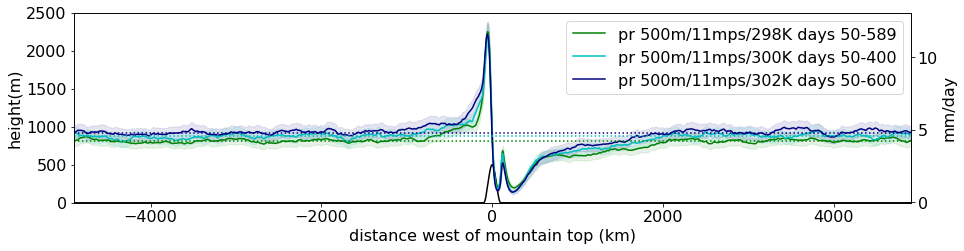

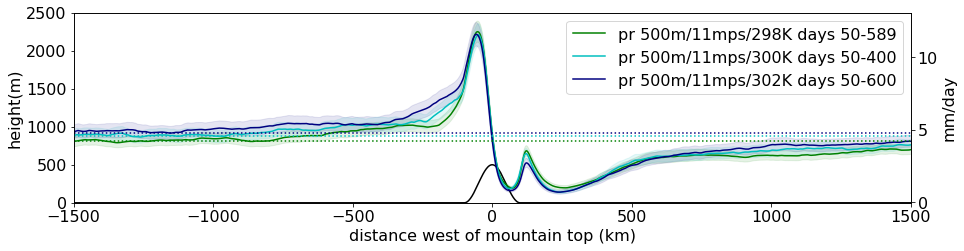

In [25]:
matplotlib.rcParams.update({'font.size':16})
for _ in range(2):
    ax,ax2=plotsection(lmhgt,figsize=(15,3.5))
    
    ax2.plot(hrdist,hr500_11_298pr,color='g'   ,label='pr 500m/11mps/298K days 50-589')
    ax2.plot(hrdist,hr500_11_300pr,color='c'   ,label='pr 500m/11mps/300K days 50-400')
    ax2.plot(hrdist,hr500_11_302pr,color='navy',label='pr 500m/11mps/302K days 50-600')
    
    ax2.fill_between(hrdist,hr500_11_298pr-2*hr500_11_298std/np.sqrt(4*350),hr500_11_298pr+2*hr500_11_298std/np.sqrt(4*350),alpha=0.1,color='g')
    ax2.fill_between(hrdist,hr500_11_300pr-2*hr500_11_300std/np.sqrt(4*350),hr500_11_300pr+2*hr500_11_300std/np.sqrt(4*350),alpha=0.1,color='c')
    ax2.fill_between(hrdist,hr500_11_302pr-2*hr500_11_302std/np.sqrt(4*350),hr500_11_302pr+2*hr500_11_302std/np.sqrt(4*350),alpha=0.1,color='navy')
    
    ax2.axhline(hr500_11_298pr[2200:3000].mean(),color='g'   ,linestyle=':')
    ax2.axhline(hr500_11_300pr[2200:3000].mean(),color='c'   ,linestyle=':')
    ax2.axhline(hr500_11_302pr[2200:3000].mean(),color='navy',linestyle=':')
        
    ax2.set_ylabel("mm/day")
    ax2.legend()
    ax.set_xlim(-4900,4900)
    ax.set_ylim(0.,2500.)
ax.set_xlim(-1500,1500)


(-1000.0, 200.0)

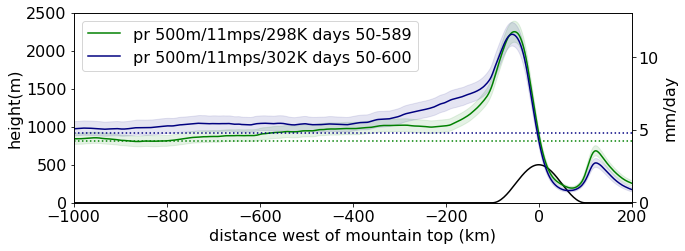

In [11]:
matplotlib.rcParams.update({'font.size':16})
ax,ax2=plotsection(lmhgt,figsize=(10,3.5))

ax2.plot(hrdist,hr500_11_298pr,color='g'   ,label='pr 500m/11mps/298K days 50-589')
ax2.plot(hrdist,hr500_11_302pr,color='navy',label='pr 500m/11mps/302K days 50-600')

ax2.fill_between(hrdist,hr500_11_298pr-2*hr500_11_298std/np.sqrt(4*350),hr500_11_298pr+2*hr500_11_298std/np.sqrt(4*350),alpha=0.1,color='g')
ax2.fill_between(hrdist,hr500_11_302pr-2*hr500_11_302std/np.sqrt(4*350),hr500_11_302pr+2*hr500_11_302std/np.sqrt(4*350),alpha=0.1,color='navy')

ax2.axhline(hr500_11_298pr[2200:3000].mean(),color='g'   ,linestyle=':')
ax2.axhline(hr500_11_302pr[2200:3000].mean(),color='navy',linestyle=':')
    
ax2.set_ylabel("mm/day")
ax2.legend()
ax.set_ylim(0.,2500.)
ax.set_xlim(-1000,200)


(-1000.0, 2000.0)

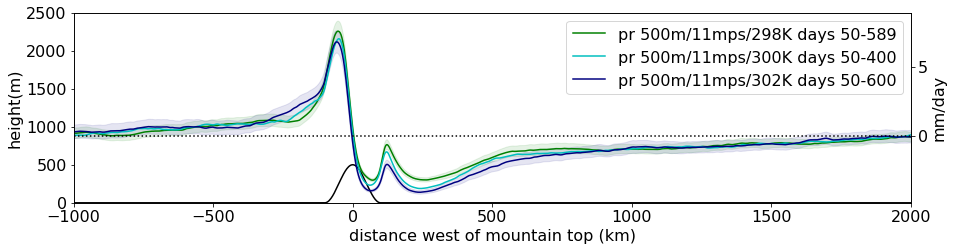

In [16]:
matplotlib.rcParams.update({'font.size':16})
ax,ax2=plotsection(lmhgt,figsize=(15,3.5))

ax2.plot(hrdist,hr500_11_298pr-hr500_11_298pr[2200:3000].mean(),color='g'   ,label='pr 500m/11mps/298K days 50-589')
ax2.plot(hrdist,hr500_11_300pr-hr500_11_300pr[2200:3000].mean(),color='c',label='pr 500m/11mps/300K days 50-400')
ax2.plot(hrdist,hr500_11_302pr-hr500_11_302pr[2200:3000].mean(),color='navy',label='pr 500m/11mps/302K days 50-600')

ax2.fill_between(hrdist,hr500_11_298pr-hr500_11_298pr[2200:3000].mean()-2*hr500_11_298std/np.sqrt(4*350),hr500_11_298pr-hr500_11_298pr[2200:3000].mean()+2*hr500_11_298std/np.sqrt(4*350),alpha=0.1,color='g')
ax2.fill_between(hrdist,hr500_11_302pr-hr500_11_302pr[2200:3000].mean()-2*hr500_11_302std/np.sqrt(4*350),hr500_11_302pr-hr500_11_302pr[2200:3000].mean()+2*hr500_11_302std/np.sqrt(4*350),alpha=0.1,color='navy')

ax2.axhline(0.,color='k'   ,linestyle=':')
    
ax2.set_ylabel("mm/day")
ax2.legend()
ax.set_ylim(0.,2500.)
ax.set_xlim(-1000,2000)


## Confidence intervals

In [15]:
peakprecip500_11_298 = np.array(hrchannel500_11_298precip[200:,:,1650:1655].mean(['south_north','west_east']))
peakprecip500_11_300 = np.array(hrchannel500_11_300precip[200:,:,1650:1655].mean(['south_north','west_east']))
peakprecip500_11_302 = np.array(hrchannel500_11_302precip[200:,:,1650:1655].mean(['south_north','west_east']))

meanpr500_11_298 = np.array(hrchannel500_11_298precip[200:,:,2200:3000].mean(['south_north','west_east']))
meanpr500_11_300 = np.array(hrchannel500_11_300precip[200:,:,2200:3000].mean(['south_north','west_east']))
meanpr500_11_302 = np.array(hrchannel500_11_302precip[200:,:,2200:3000].mean(['south_north','west_east']))

In [63]:
def CI95_ratio(a,b,normalization=1):
    """Compute a confidence interval for the percentage increase 100*(b/a-1)/normalization at the level CI_level (0<CI_level<100), using the central limit theorem"""
    meanratio = b.mean()/a.mean()
    deltaratio = meanratio*np.sqrt( (1.96*np.std(a)/np.sqrt(len(a))/a.mean())**2 + (1.96*np.std(b)/np.sqrt(len(b))/b.mean())**2)
    return 100*(meanratio-1)/normalization , 100*(meanratio-1-deltaratio)/normalization , 100*(meanratio-1+deltaratio)/normalization

In [71]:
print("Change in peak precip is %.1f %%/K (95%% CI = [%.1f to %.1f])"%CI95_ratio(peakprecip500_11_300,peakprecip500_11_302,normalization=2))

Change in peak precip is -0.3 %/K (95% CI = [-5.0 to 4.4])


In [75]:
print("Change in mean upstream P is %.1f %%/K (95%% CI = [%.1f to %.1f])"%CI95_ratio(meanpr500_11_300,meanpr500_11_302,normalization=2))

Change in mean upstream P is 2.8 %/K (95% CI = [1.6 to 4.0])


In [76]:
print("Change in peak P' is %.1f %%/K (95%% CI = [%.1f to %.1f])"%CI95_ratio(peakprecip500_11_300-meanpr500_11_300.mean(),peakprecip500_11_302-meanpr500_11_302.mean(),normalization=2))

Change in peak P' is -2.3 %/K (95% CI = [-9.9 to 5.3])


Using a bigger window doesn't reduce the uncertainty.

In [78]:
peakprecip500_11_300_wide = np.array(hrchannel500_11_300precip[200:,:,1640:1665].mean(['south_north','west_east']))
peakprecip500_11_302_wide = np.array(hrchannel500_11_302precip[200:,:,1640:1665].mean(['south_north','west_east']))
print("Change in peak precip is %.1f %%/K (95%% CI = [%.1f to %.1f])"%CI95_ratio(peakprecip500_11_300_wide,peakprecip500_11_302_wide,normalization=2))

Change in peak precip is 0.3 %/K (95% CI = [-4.4 to 4.9])


Bootstrapping ?

In [13]:
def select_bootstrap_sample(distribution):
    n=len(distribution)
    return distribution[np.random.randint(0,n,size=n)]
def bootstrap_CI_pctincrease(a,b,CI_level,nsamples=100,normalization=1):
    """Compute a confidence interval for the percentage increase 100*(b/a-1)/normalization at the level CI_level (0<CI_level<100), using nsamples bootstrap samples"""
    pctincreases = np.zeros(nsamples)
    for i in range(nsamples):
        pctincreases[i]=100*(select_bootstrap_sample(b).mean()/select_bootstrap_sample(a).mean()-1)/normalization
    return pctincreases.mean(),np.percentile(pctincreases,50-CI_level/2),np.percentile(pctincreases,50+CI_level/2)

In [79]:
print("With bootstrapping :")
print("Change in peak precip is %.1f %%/K (95%% CI = [%.1f to %.1f])"%bootstrap_CI_pctincrease(peakprecip500_11_300,peakprecip500_11_302,95,nsamples=10000,normalization=2))
print("Change in mean upstream P is %.1f %%/K (95%% CI = [%.1f to %.1f])"%bootstrap_CI_pctincrease(meanpr500_11_300,meanpr500_11_302,95,nsamples=10000,normalization=2))
print("Change in peak P' is %.1f %%/K (95%% CI = [%.1f to %.1f])"%bootstrap_CI_pctincrease(peakprecip500_11_300-meanpr500_11_300.mean(),peakprecip500_11_302-meanpr500_11_302.mean(),95,nsamples=10000,normalization=2))

With bootstrapping :
Change in peak precip is -0.3 %/K (95% CI = [-4.8 to 4.6])
Change in mean upstream P is 2.8 %/K (95% CI = [1.6 to 4.1])
Change in peak P' is -2.2 %/K (95% CI = [-9.3 to 6.1])


In [28]:
print("With bootstrapping, and 4K difference between runs :")
print("Change in peak precip is %.1f %%/K (95%% CI = [%.1f to %.1f])"%bootstrap_CI_pctincrease(peakprecip500_11_298,peakprecip500_11_302,95,nsamples=10000,normalization=4))
print("Change in mean upstream P is %.1f %%/K (95%% CI = [%.1f to %.1f])"%bootstrap_CI_pctincrease(meanpr500_11_298,meanpr500_11_302,95,nsamples=10000,normalization=4))
print("Change in peak P' is %.1f %%/K (95%% CI = [%.1f to %.1f])"%bootstrap_CI_pctincrease(peakprecip500_11_298-meanpr500_11_298.mean(),peakprecip500_11_302-meanpr500_11_302.mean(),95,nsamples=10000,normalization=4))

With bootstrapping, and 4K difference between runs :
Change in peak precip is -0.5 %/K (95% CI = [-2.3 to 1.3])
Change in mean upstream P is 3.5 %/K (95% CI = [3.0 to 4.1])
Change in peak P' is -2.8 %/K (95% CI = [-5.4 to -0.0])


In [24]:
peakprecip500_11_298_100 = np.array(hrchannel500_11_298precip[200:,:,1635+100//3:1635+200//3].mean(['south_north','west_east']))
peakprecip500_11_302_100 = np.array(hrchannel500_11_302precip[200:,:,1635+100//3:1635+200//3].mean(['south_north','west_east']))

peakprecip500_11_298_200 = np.array(hrchannel500_11_298precip[200:,:,1635+200//3:1635+300//3].mean(['south_north','west_east']))
peakprecip500_11_302_200 = np.array(hrchannel500_11_302precip[200:,:,1635+200//3:1635+300//3].mean(['south_north','west_east']))

peakprecip500_11_298_300 = np.array(hrchannel500_11_298precip[200:,:,1635+300//3:1635+400//3].mean(['south_north','west_east']))
peakprecip500_11_302_300 = np.array(hrchannel500_11_302precip[200:,:,1635+300//3:1635+400//3].mean(['south_north','west_east']))

peakprecip500_11_298_400 = np.array(hrchannel500_11_298precip[200:,:,1635+400//3:1635+500//3].mean(['south_north','west_east']))
peakprecip500_11_302_400 = np.array(hrchannel500_11_302precip[200:,:,1635+400//3:1635+500//3].mean(['south_north','west_east']))


In [26]:
print("100-200 km : change in P is %.1f %%/K [%.1f to %.1f], P' is %.1f %%/K [%.1f to %.1f]"%(*bootstrap_CI_pctincrease(peakprecip500_11_298_100,peakprecip500_11_302_100,95,nsamples=10000,normalization=4),*bootstrap_CI_pctincrease(peakprecip500_11_298_100-meanpr500_11_298.mean(),peakprecip500_11_302_100-meanpr500_11_302.mean(),95,nsamples=10000,normalization=4)))
print("200-300 km : change in P is %.1f %%/K [%.1f to %.1f], P' is %.1f %%/K [%.1f to %.1f]"%(*bootstrap_CI_pctincrease(peakprecip500_11_298_200,peakprecip500_11_302_200,95,nsamples=10000,normalization=4),*bootstrap_CI_pctincrease(peakprecip500_11_298_200-meanpr500_11_298.mean(),peakprecip500_11_302_200-meanpr500_11_302.mean(),95,nsamples=10000,normalization=4)))
print("300-400 km : change in P is %.1f %%/K [%.1f to %.1f], P' is %.1f %%/K [%.1f to %.1f]"%(*bootstrap_CI_pctincrease(peakprecip500_11_298_300,peakprecip500_11_302_300,95,nsamples=10000,normalization=4),*bootstrap_CI_pctincrease(peakprecip500_11_298_300-meanpr500_11_298.mean(),peakprecip500_11_302_300-meanpr500_11_302.mean(),95,nsamples=10000,normalization=4)))
print("400-500 km : change in P is %.1f %%/K [%.1f to %.1f], P' is %.1f %%/K [%.1f to %.1f]"%(*bootstrap_CI_pctincrease(peakprecip500_11_298_400,peakprecip500_11_302_400,95,nsamples=10000,normalization=4),*bootstrap_CI_pctincrease(peakprecip500_11_298_400-meanpr500_11_298.mean(),peakprecip500_11_302_400-meanpr500_11_302.mean(),95,nsamples=10000,normalization=4)))



100-200 km : change in P is 5.3 %/K [2.8 to 7.8], P' is 8.9 %/K [1.5 to 17.7]
200-300 km : change in P is 5.6 %/K [2.9 to 8.4], P' is 14.8 %/K [0.9 to 35.0]
300-400 km : change in P is 2.2 %/K [-0.3 to 4.7], P' is -3.2 %/K [-14.2 to 11.4]
400-500 km : change in P is 1.7 %/K [-0.7 to 4.3], P' is -7.0 %/K [-19.0 to 9.6]


In [16]:
peakprecip500_11_298_150 = np.array(hrchannel500_11_298precip[200:,:,1635+150//3:1635+300//3].mean(['south_north','west_east']))
peakprecip500_11_302_150 = np.array(hrchannel500_11_302precip[200:,:,1635+150//3:1635+300//3].mean(['south_north','west_east']))
print("150-300 km : change in P is %.1f %%/K [%.1f to %.1f], P' is %.1f %%/K [%.1f to %.1f]"%(*bootstrap_CI_pctincrease(peakprecip500_11_298_150,peakprecip500_11_302_150,95,nsamples=10000,normalization=4),*bootstrap_CI_pctincrease(peakprecip500_11_298_150-meanpr500_11_298.mean(),peakprecip500_11_302_150-meanpr500_11_302.mean(),95,nsamples=10000,normalization=4)))

150-300 km : change in P is 6.1 %/K [3.6 to 8.8], P' is 16.0 %/K [3.8 to 33.0]


## N and q vertical profiles

In [17]:
def compute_N(T,pfactor,pname='pressure'):
    """T in K, p in Pa and N in s"""
    g = 9.81; R=287.
    rho = pfactor*T[pname]/R/T
    theta = T*(pfactor*T[pname]/1e5)**(-0.287)
    return np.sqrt(-rho*g*g/theta*theta.differentiate(pname)/pfactor)

In [21]:
def load_p_var(foldername,ref_ds,varname,thresh):
    try:
        var   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/%s/diags/wrf.%s.days50-600.nc'%(foldername,varname))
    except FileNotFoundError:
        var   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/%s/diags/wrf.%s.days50-400.nc'%(foldername,varname))
    var   = var.where(var >thresh)  
    return change_coords_pl(ref_ds,var)

tmean500_11_298_p = load_p_var("channel.wrf.100x2.mountain.500m.11mps.298K.3km",hrchannel500_11_300p,'T_PL',100.)
tmean500_11_300_p = load_p_var("channel.wrf.100x2.mountain.500m.11mps.3km"     ,hrchannel500_11_300p,'T_PL',100.)
tmean500_11_302_p = load_p_var("channel.wrf.100x2.mountain.500m.11mps.302K.3km",hrchannel500_11_300p,'T_PL',100.)
qmean500_11_298_p = load_p_var("channel.wrf.100x2.mountain.500m.11mps.298K.3km",hrchannel500_11_300p,'Q_PL',0.)
qmean500_11_300_p = load_p_var("channel.wrf.100x2.mountain.500m.11mps.3km"     ,hrchannel500_11_300p,'Q_PL',0.)
qmean500_11_302_p = load_p_var("channel.wrf.100x2.mountain.500m.11mps.302K.3km",hrchannel500_11_300p,'Q_PL',0.)

tmean500_11_298_p_upstream = tmean500_11_298_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn')
tmean500_11_300_p_upstream = tmean500_11_300_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn')
tmean500_11_302_p_upstream = tmean500_11_302_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn')
qmean500_11_298_p_upstream = qmean500_11_298_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn')
qmean500_11_300_p_upstream = qmean500_11_300_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn')
qmean500_11_302_p_upstream = qmean500_11_302_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn')

tmean500_11_298_p_RCE = tmean500_11_298_p.sel(distance_from_mtn=slice(-2000,-3000)).mean('distance_from_mtn')
tmean500_11_300_p_RCE = tmean500_11_300_p.sel(distance_from_mtn=slice(-2000,-3000)).mean('distance_from_mtn')
tmean500_11_302_p_RCE = tmean500_11_302_p.sel(distance_from_mtn=slice(-2000,-3000)).mean('distance_from_mtn')
qmean500_11_298_p_RCE = qmean500_11_298_p.sel(distance_from_mtn=slice(-2000,-3000)).mean('distance_from_mtn')
qmean500_11_300_p_RCE = qmean500_11_300_p.sel(distance_from_mtn=slice(-2000,-3000)).mean('distance_from_mtn')
qmean500_11_302_p_RCE = qmean500_11_302_p.sel(distance_from_mtn=slice(-2000,-3000)).mean('distance_from_mtn')

In [25]:
N500_11_298_RCE=compute_N(tmean500_11_298_p_RCE,100)
N500_11_300_RCE=compute_N(tmean500_11_300_p_RCE,100)
N500_11_302_RCE=compute_N(tmean500_11_302_p_RCE,100)

N500_11_298_upstream=compute_N(tmean500_11_298_p_upstream,100)
N500_11_300_upstream=compute_N(tmean500_11_300_p_upstream,100)
N500_11_302_upstream=compute_N(tmean500_11_302_p_upstream,100)

(0.005, 0.015)

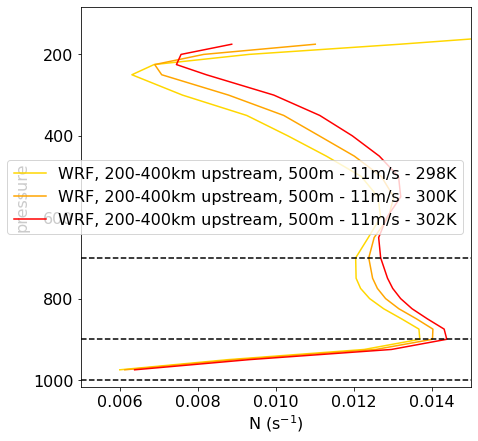

In [27]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
N500_11_298_upstream.plot(ax=ax,y='pressure',yincrease=False,color='gold',label='WRF, 200-400km upstream, 500m - 11m/s - 298K')
N500_11_300_upstream.plot(ax=ax,y='pressure',yincrease=False,color='orange',label='WRF, 200-400km upstream, 500m - 11m/s - 300K')
N500_11_302_upstream.plot(ax=ax,y='pressure',yincrease=False,color='red'   ,label='WRF, 200-400km upstream, 500m - 11m/s - 302K')
ax.set_xlabel(r"N (s$^{-1})$")
ax.axvline(0.,color='k',linestyle='--')
ax.axhline(1000.,color='k',linestyle='--')
ax.axhline(900.,color='k',linestyle='--')
ax.axhline(700.,color='k',linestyle='--')
ax.legend()
ax.set_xlim(0.005,0.015)

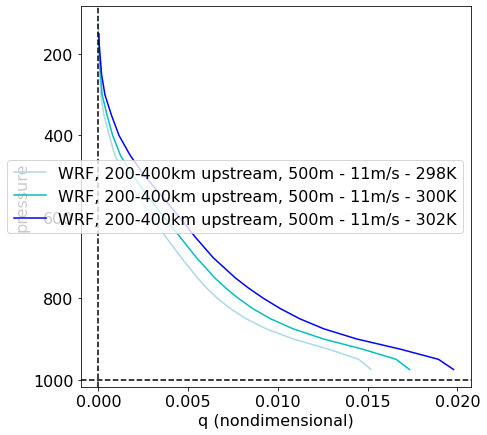

In [28]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
qmean500_11_298_p_upstream.plot(ax=ax,y='pressure',yincrease=False,color='lightblue',label='WRF, 200-400km upstream, 500m - 11m/s - 298K')
qmean500_11_300_p_upstream.plot(ax=ax,y='pressure',yincrease=False,color='c',label='WRF, 200-400km upstream, 500m - 11m/s - 300K')
qmean500_11_302_p_upstream.plot(ax=ax,y='pressure',yincrease=False,color='b',label='WRF, 200-400km upstream, 500m - 11m/s - 302K')

ax.set_xlabel("q (nondimensional)")
ax.axvline(0.,color='k',linestyle='--')
ax.axhline(1000.,color='k',linestyle='--')
ax.legend()

In [20]:
N300 = N500_11_300.sel(pressure=slice(900.,699.)).mean()
N302 = N500_11_302.sel(pressure=slice(900.,699.)).mean()
qL300 = qmean500_11_300_p_upstream.sel(pressure=slice(900.,699.)).mean()
qL302 = qmean500_11_302_p_upstream.sel(pressure=slice(900.,699.)).mean()
print("Increase in q : %.1f%%/K"%((np.sqrt(qL302/qL300)-1)*100))
print("Increase in N : %.1f%%/K"%((np.sqrt(N302/N300)-1)*100))

Increase in q : 8.0%/K
Increase in N : 1.2%/K


In [98]:
Z_p = change_coords_press(hrchannel500_11_300p, hrchannel500_11_300p.GHT_PL[-1,:,:,1635+200//3:1635+400//3].mean(['south_north','west_east'])).load()
dqdz_300 = qmean500_11_300_p_upstream.assign_coords({'z':Z_p}).differentiate('z')[3:11].mean()
dqdz_302 = qmean500_11_302_p_upstream.assign_coords({'z':Z_p}).differentiate('z')[3:11].mean()
print("Increase in dq/dz : %.1f%%/K"%((np.sqrt(dqdz_302/dqdz_300)-1)*100))

Increase in dq/dz : 5.7%/K


## W

In [39]:
w500_11_300mean_s = interp_eta_to_pressure(hrchannel500_11_300,change_coords_eta(hrchannel500_11_300,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.3km/diags/wrf.W.days50-400.nc'),staggered=True))
w500_11_302mean_s = interp_eta_to_pressure(hrchannel500_11_302,change_coords_eta(hrchannel500_11_302,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/diags/wrf.W.days50-400.nc'),staggered=True))


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/plot/plot.py:934: UserWarning: The following kwargs were not used by contour: 'color'
  primitive = ax.contour(x, y, z, **kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/plot/plot.py:934: UserWarning: The following kwargs were not used by contour: 'color', 'linestyle'
  primitive = ax.contour(x, y, z, **kwargs)


(-2100.0, 2100.0)

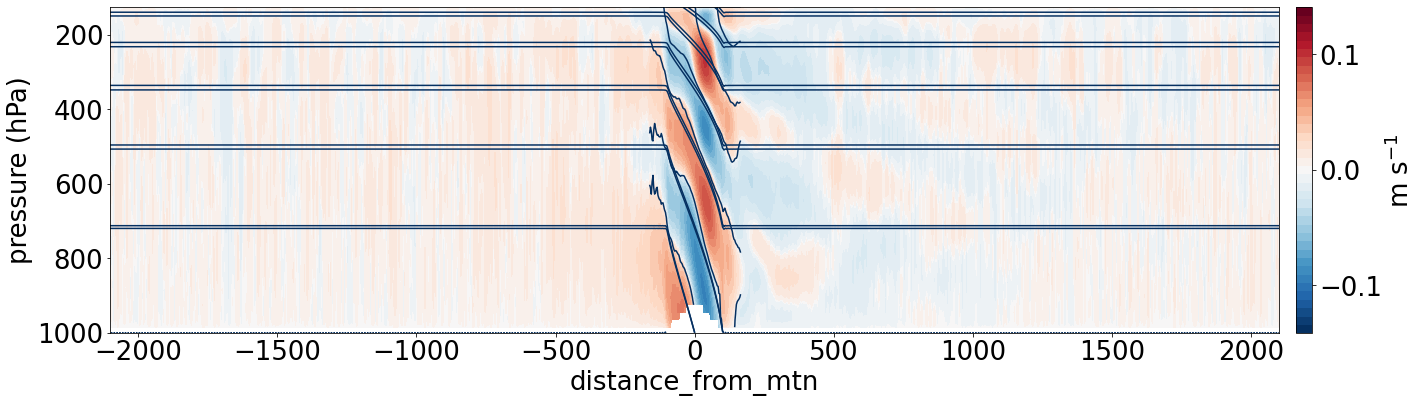

In [40]:
matplotlib.rcParams.update({'font.size': 26})
def levs(wmax,n):
    x=np.linspace(-wmax**(1/n),wmax**(1/n),40)
    return np.sign(x)*np.abs(x)**n

fig,ax=plt.subplots(1,1,figsize=(25,6))
wlevs=levs(0.2,2)
wticks=[-.5,-.4,-.1,0.,.1,.4,.5]

w500_11_300mean_s.plot.contourf(ax=ax,yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':r'm s$^{-1}$','pad':.012})#,cmap=plt.cm.RdBu)
w500_11_302mean_s[:,1580:1690].plot.contour(ax=ax,yincrease=False, levels=[0.],color='k')

xx,hx = topographic_profile('cos',A=500)
linear_w_N(xx,hx,11,N=0.012,vert_coord='p').plot.contour(ax=ax,y='pressure',yincrease=False,levels=[0.],color='grey')
linear_w_N(xx,hx,11,N=0.012*1.015**2,vert_coord='p').plot.contour( ax=ax,y='pressure',yincrease=False,levels=[0.],color='grey',linestyle='--')

ax.set_ylabel("pressure (hPa)")
ax.set_xlim(-2100,2100)

## TdL,qdL

In [41]:
def hatprime(var,idx1,idx2):
    """Vertically average variable between two pressure levels indicated by their indices (idx1 and idx2), and take deviation from upstream value"""
    varhat = var[idx1:idx2].integrate('pressure')/(var.pressure[idx2]-var.pressure[idx1])
    return varhat - varhat[2200:2400].mean('distance_from_mtn')
pT_ov_g=8000
cp=1004.
Lc=2.5e6
g=9.81

tmean500_11_298_p_hat_prime = hatprime(tmean500_11_298_p,3,11)
tmean500_11_300_p_hat_prime = hatprime(tmean500_11_300_p,3,11)
tmean500_11_302_p_hat_prime = hatprime(tmean500_11_302_p,3,11)
qmean500_11_298_p_hat_prime = Lc/cp*hatprime(qmean500_11_298_p,3,11) # convert to K
qmean500_11_300_p_hat_prime = Lc/cp*hatprime(qmean500_11_300_p,3,11) # convert to K
qmean500_11_302_p_hat_prime = Lc/cp*hatprime(qmean500_11_302_p,3,11) # convert to K

increase in max, WRF: T = 2.5%/K,  q = 3.2%/K


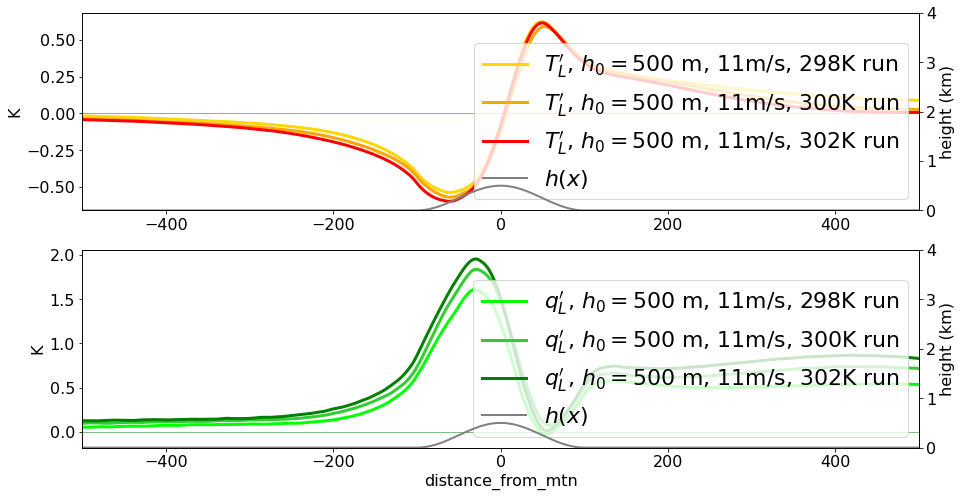

In [42]:
fig,(ax,ax2) = plt.subplots(2,1,figsize=(15,8))
axm=ax.twinx()
ax2m=ax2.twinx()
xx,hx = topographic_profile('cos',A=500)

# Panel a : temperature deviations
tmean500_11_298_p_hat_prime.plot( ax=ax,color='gold'   ,linewidth=3,label=r"$T_L'$, $h_0=500$ m, 11m/s, 298K run")
tmean500_11_300_p_hat_prime.plot( ax=ax,color='orange' ,linewidth=3,label=r"$T_L'$, $h_0=500$ m, 11m/s, 300K run")
tmean500_11_302_p_hat_prime.plot( ax=ax,color='red'    ,linewidth=3,label=r"$T_L'$, $h_0=500$ m, 11m/s, 302K run")
ax.axhline(0.,linestyle='-',linewidth='0.5',color='red')

# Panel b : moisture deviations
qmean500_11_298_p_hat_prime.plot( ax=ax2,color='lime'     ,linewidth=3,label=r"$q_L'$, $h_0=500$ m, 11m/s, 298K run")
qmean500_11_300_p_hat_prime.plot( ax=ax2,color='limegreen',linewidth=3,label=r"$q_L'$, $h_0=500$ m, 11m/s, 300K run")
qmean500_11_302_p_hat_prime.plot( ax=ax2,color='g'        ,linewidth=3,label=r"$q_L'$, $h_0=500$ m, 11m/s, 302K run")
ax2.axhline(0.,linestyle='-',linewidth='0.5',color='green')


for a,am in (ax,axm),(ax2,ax2m):
    a.set_xlim(-500,500)
    a.set_ylabel("K")
    a.legend(fontsize=20)
    
    am.plot(xx/1000,hx/1000,label=r"$h(x)$",color='gray',linewidth=2)
    am.set_ylabel('height (km)')
    am.set_ylim(0,4)
    
    lines, labels = a.get_legend_handles_labels()
    lines2, labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2,fontsize=22,loc=4)

ax.set_xlabel('')
print("increase in max, WRF: T = %.1f%%/K,  q = %.1f%%/K"%(100*(tmean500_11_302_p_hat_prime.min()/tmean500_11_300_p_hat_prime.min()-1)/2,100*(qmean500_11_302_p_hat_prime.max()/qmean500_11_300_p_hat_prime.max()-1)/2))



In [48]:
def prime(var):
    return var - var[:,2200:2400].mean('distance_from_mtn')

tmean500_11_298_p_prime = prime(tmean500_11_298_p)
tmean500_11_302_p_prime = prime(tmean500_11_302_p)
qmean500_11_298_p_prime = Lc/cp*prime(qmean500_11_298_p)
qmean500_11_302_p_prime = Lc/cp*prime(qmean500_11_302_p)

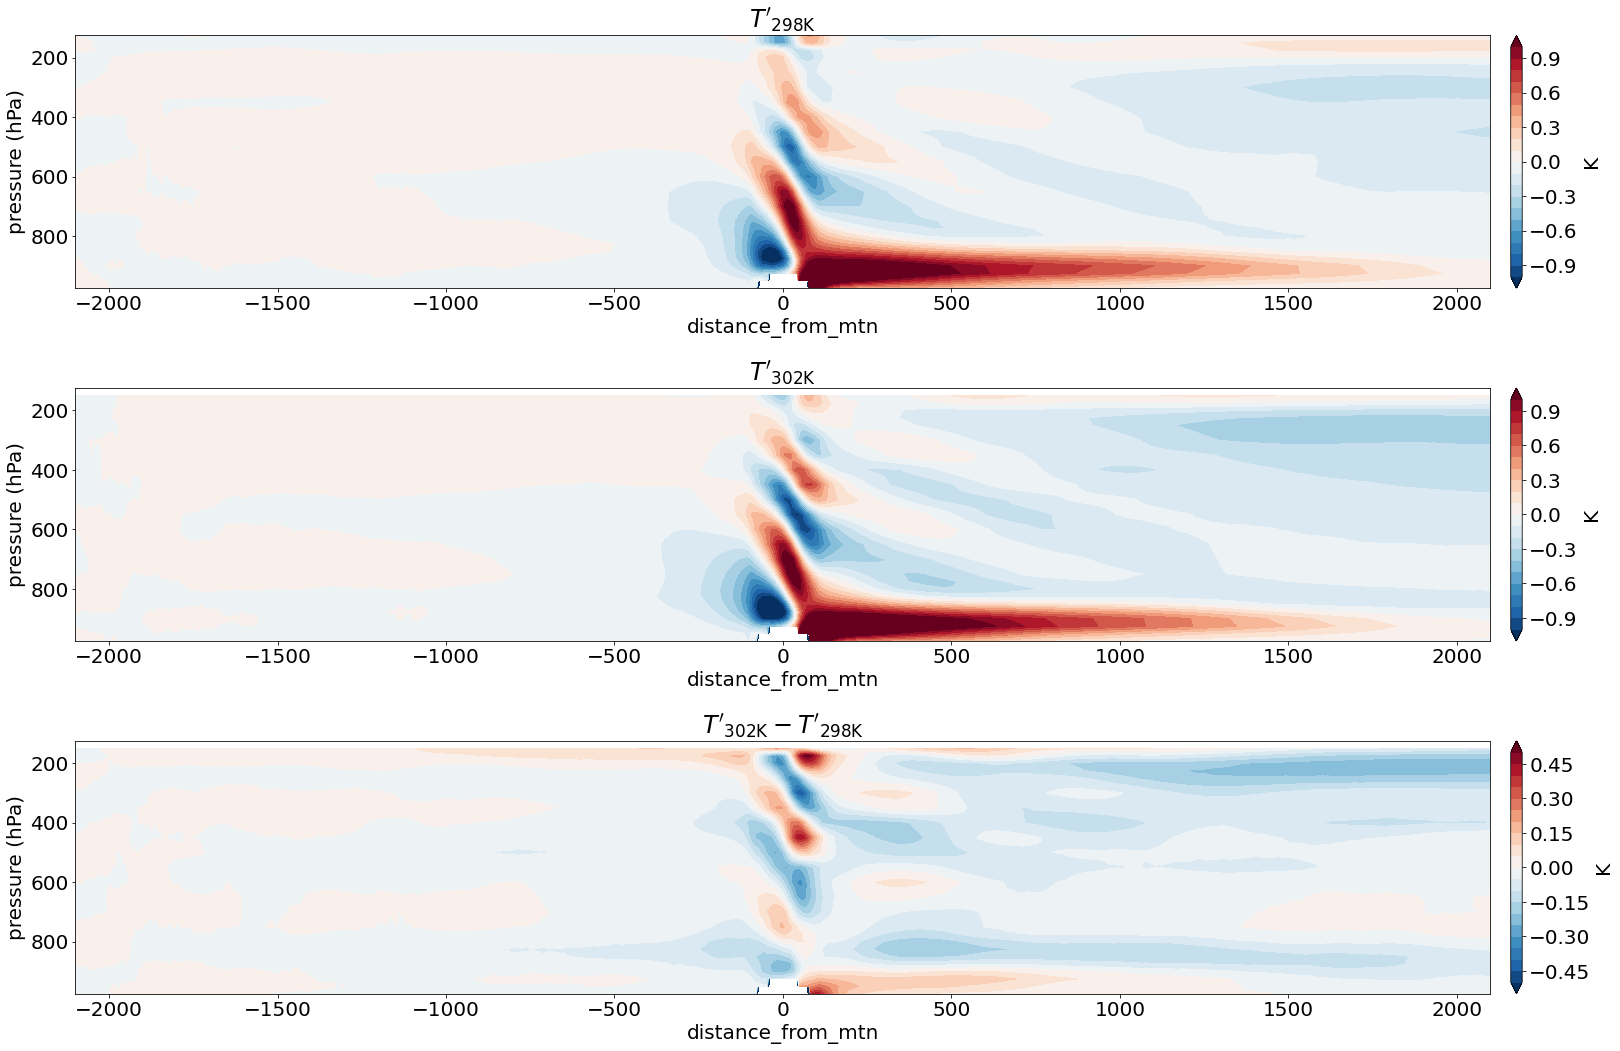

In [53]:
matplotlib.rcParams.update({'font.size': 20})
fig,axs=plt.subplots(3,1,figsize=(25,15))

tlevs = np.arange(-1.,1.1,0.1)
dtlevs = np.arange(-.5,.51,0.05)
tmean500_11_298_p_prime.plot.contourf(ax=axs[0],yincrease=False, levels=tlevs,cbar_kwargs={'label':'K','pad':.012})#,cmap=plt.cm.RdBu)
tmean500_11_302_p_prime.plot.contourf(ax=axs[1],yincrease=False, levels=tlevs,cbar_kwargs={'label':'K','pad':.012})#,cmap=plt.cm.RdBu)
(tmean500_11_302_p_prime-tmean500_11_298_p_prime).plot.contourf(ax=axs[2],yincrease=False, levels=dtlevs,cbar_kwargs={'label':'K','pad':.012})#,cmap=plt.cm.RdBu)

for ax in axs:
    ax.set_ylabel("pressure (hPa)")
    ax.set_xlim(-2100,2100)
axs[0].set_title(r"$T'_{\mathrm{298K}}$")
axs[1].set_title(r"$T'_{\mathrm{302K}}$")
axs[2].set_title(r"$T'_{\mathrm{302K}} - T'_{\mathrm{298K}}$")
fig.tight_layout()

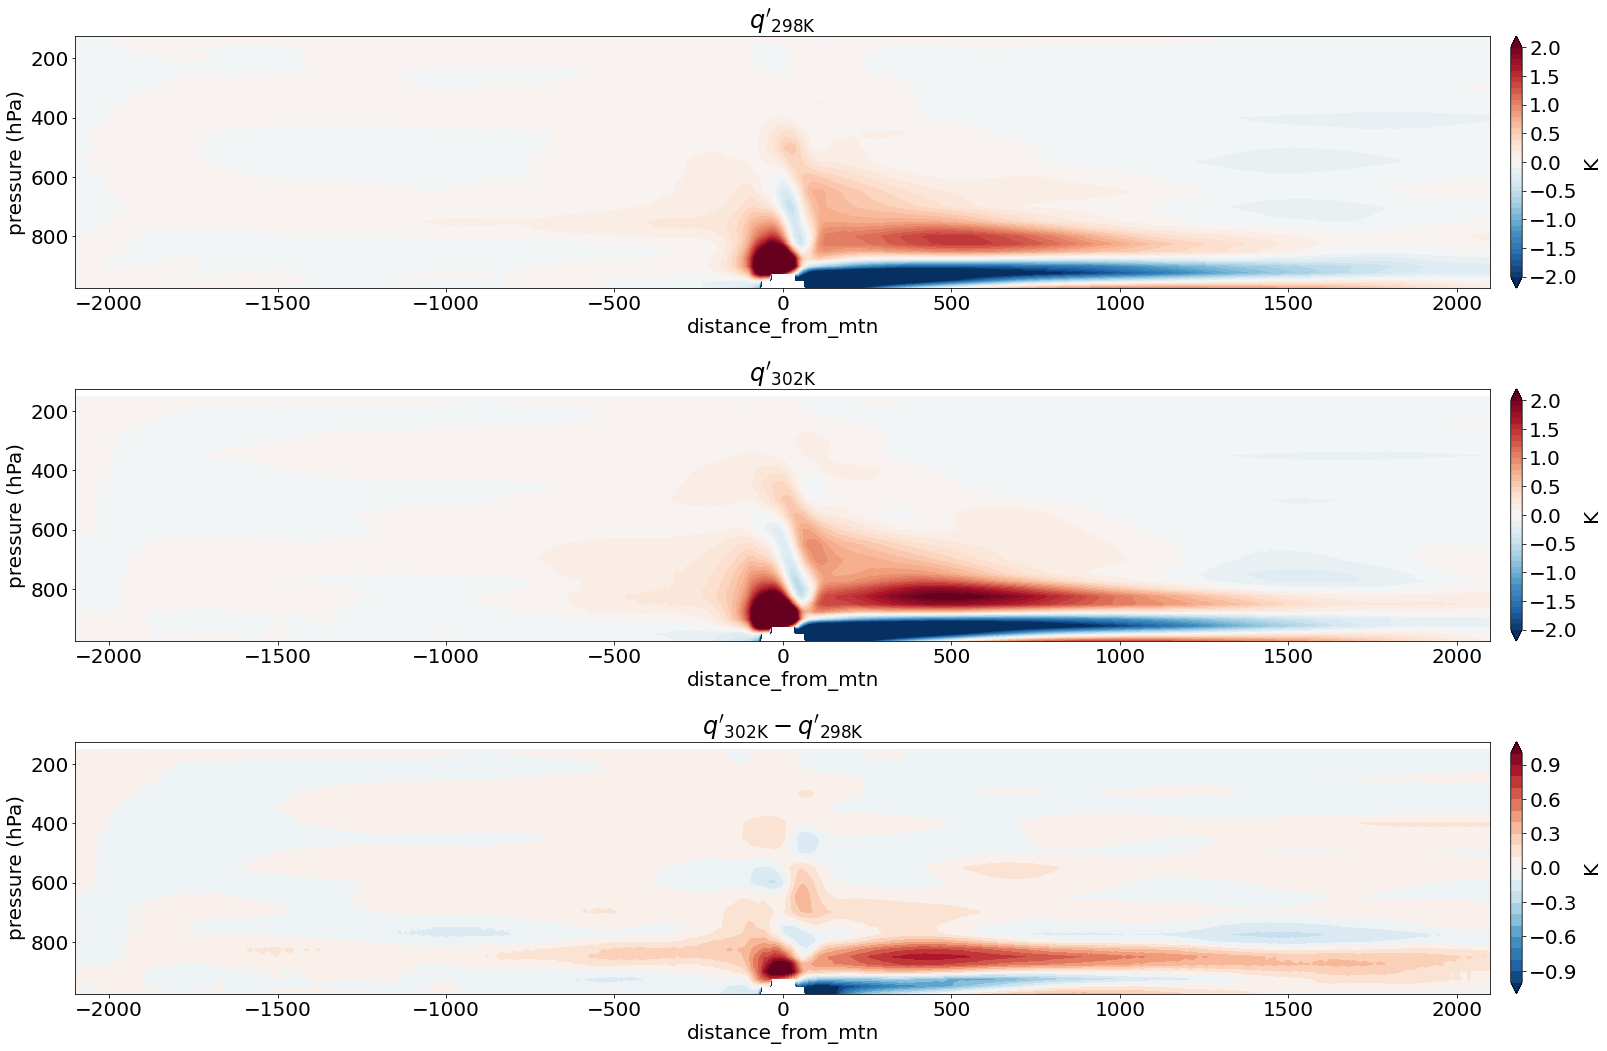

In [57]:
matplotlib.rcParams.update({'font.size': 20})
fig,axs=plt.subplots(3,1,figsize=(25,15))

qlevs = np.arange(-2.,2.1,0.1)
dqlevs = np.arange(-1.,1.1,0.1)
qmean500_11_298_p_prime.plot.contourf(ax=axs[0],yincrease=False, levels=qlevs,cbar_kwargs={'label':'K','pad':.012})#,cmap=plt.cm.RdBu)
qmean500_11_302_p_prime.plot.contourf(ax=axs[1],yincrease=False, levels=qlevs,cbar_kwargs={'label':'K','pad':.012})#,cmap=plt.cm.RdBu)
(qmean500_11_302_p_prime-qmean500_11_298_p_prime).plot.contourf(ax=axs[2],yincrease=False, levels=dqlevs,cbar_kwargs={'label':'K','pad':.012})#,cmap=plt.cm.RdBu)

for ax in axs:
    ax.set_ylabel("pressure (hPa)")
    ax.set_xlim(-2100,2100)
axs[0].set_title(r"$q'_{\mathrm{298K}}$")
axs[1].set_title(r"$q'_{\mathrm{302K}}$")
axs[2].set_title(r"$q'_{\mathrm{302K}} - q'_{\mathrm{298K}}$")
fig.tight_layout()

# Precipitation distribution and extremes

In [11]:
from dask.distributed import Client
client = Client()

In [12]:
hrchannel500_11_300precip = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.3km/diags/wrf.precip.days0-400.nc')
hrchannel500_11_302precip = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/diags/wrf.precip.days0-400.nc')
hrchannel500_11_300precip_hourly = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.3km/diags/wrf.precip.hourly.days0-400.nc')
hrchannel500_11_302precip_hourly = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/diags/wrf.precip.hourly.days0-600.nc')


In [13]:
def plot_cdf(ax,values,lbl):
    """Values must be a 1D array sorted increasingly"""
    counts=np.arange(len(values))[::-1]
    select = np.concatenate([[0],np.where(values[1:]-values[:-1]>0)[0]])
    ax.plot(values[select],counts[select]/counts[0],label=lbl)
    
def plot_percentiles(ax,values,lbl,color,linestyle):
    """Values must be a 1D array sorted increasingly"""
    n=len(values)
    percentileranks= np.arange(n)/n*100
    select = np.concatenate([[0],np.where(values[1:]-values[:-1]>0)[0]])[::-1]
    ax.plot(percentileranks[select],values[select],label=lbl,color=color,linestyle=linestyle)

def plot_deltapercentiles(ax,values,values2,lbl,color,linestyle,normalization=2):
    n=len(values)
    percentileranks= np.arange(n)/n*100
    select = np.concatenate([[0],np.where(values[1:]-values[:-1]>0)[0]])[::-1]
    ax.plot(percentileranks[select],100*(values2[select]/values[select]-1)/normalization,label=lbl,color=color,linestyle=linestyle)
    
    

## CDFs & change by percentile

In [14]:
%%time
upstream_precip_300_sorted = np.sort(np.array(hrchannel500_11_300precip[200:,:,2200:3000]).reshape(-1))
upstream_precip_302_sorted = np.sort(np.array(hrchannel500_11_302precip[200:,:,2200:3000]).reshape(-1))
mountain_precip_300_sorted = np.sort(np.array(hrchannel500_11_300precip[200:,:,1650:1655]).reshape(-1))
mountain_precip_302_sorted = np.sort(np.array(hrchannel500_11_302precip[200:,:,1650:1655]).reshape(-1))


CPU times: user 9.83 s, sys: 2.49 s, total: 12.3 s
Wall time: 12.3 s


In [17]:
%%time
# Load a dask client to speedup
upstream_precip_300_hourly_sorted_sub = np.sort(np.array(hrchannel500_11_300precip_hourly[1200:6960:6,:,2200:3000]).reshape(-1))
upstream_precip_302_hourly_sorted_sub = np.sort(np.array(hrchannel500_11_302precip_hourly[1200:6960:6,:,2200:3000]).reshape(-1))


CPU times: user 4.51 s, sys: 6.45 s, total: 11 s
Wall time: 19.8 s


In [18]:
%%time
mountain_precip_300_hourly_sorted = np.sort(np.array(hrchannel500_11_300precip_hourly[1200:6960,:,1650:1655]).reshape(-1))
mountain_precip_302_hourly_sorted = np.sort(np.array(hrchannel500_11_302precip_hourly[1200:6960,:,1650:1655]).reshape(-1))


CPU times: user 98.1 ms, sys: 8.78 s, total: 8.88 s
Wall time: 8.47 s


CPU times: user 820 ms, sys: 911 ms, total: 1.73 s
Wall time: 1.79 s


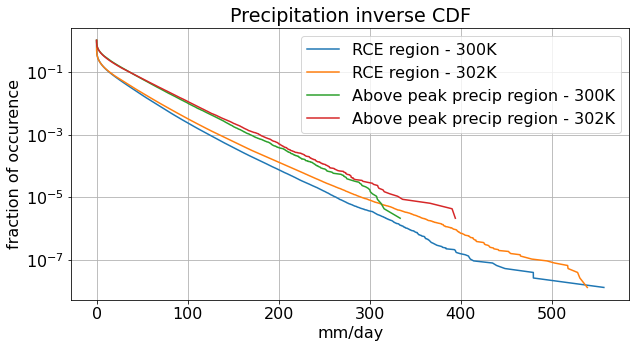

In [11]:
%%time
_,ax=plt.subplots(figsize=(10,5))
plot_cdf(ax,upstream_precip_300_sorted,'RCE region - 300K')
plot_cdf(ax,upstream_precip_302_sorted,'RCE region - 302K')

plot_cdf(ax,mountain_precip_300_sorted,'Above peak precip region - 300K')
plot_cdf(ax,mountain_precip_302_sorted,'Above peak precip region - 302K')


ax.set_yscale('log')
ax.set_title('Precipitation inverse CDF')
ax.set_xlabel('mm/day')
ax.set_ylabel('fraction of occurence')

ax.legend()
ax.grid()

CPU times: user 1.67 s, sys: 1.42 s, total: 3.09 s
Wall time: 2.92 s


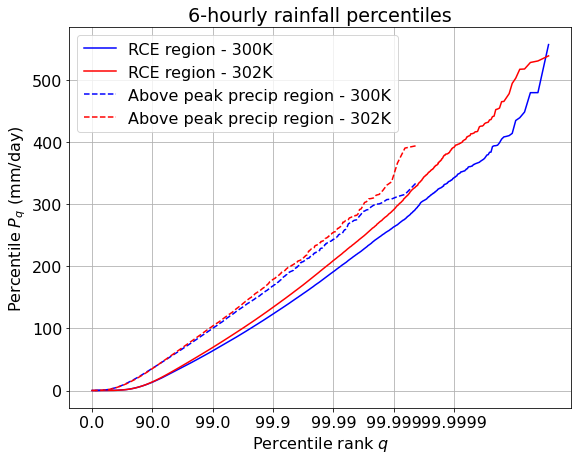

In [36]:
%%time
_,ax=plt.subplots(1,1,figsize=(9,7))

plot_percentiles(ax,upstream_precip_300_sorted,'RCE region - 300K','b','-')
plot_percentiles(ax,upstream_precip_302_sorted,'RCE region - 302K','r','-')

plot_percentiles(ax,mountain_precip_300_sorted,'Above peak precip region - 300K','b','--')
plot_percentiles(ax,mountain_precip_302_sorted,'Above peak precip region - 302K','r','--')


ax.set_title('6-hourly rainfall percentiles')
ax.set_xlabel(r'Percentile rank $q$')
ax.set_ylabel(r'Percentile $P_q$ (mm/day)')
ax.set_xscale('function', functions=(lambda x:-np.log(100-x), lambda y:100-np.exp(-y)))
ticks = [100.-10**n for n in range(2,-5,-1)]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)

ax.legend()
ax.grid()

CPU times: user 1.11 s, sys: 988 ms, total: 2.09 s
Wall time: 1.98 s


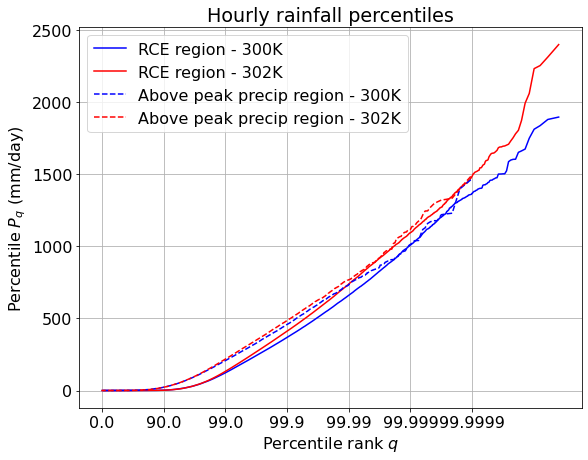

In [37]:
%%time
_,ax=plt.subplots(1,1,figsize=(9,7))

plot_percentiles(ax,upstream_precip_300_hourly_sorted_sub,'RCE region - 300K','b','-')
plot_percentiles(ax,upstream_precip_302_hourly_sorted_sub,'RCE region - 302K','r','-')

plot_percentiles(ax,mountain_precip_300_hourly_sorted,'Above peak precip region - 300K','b','--')
plot_percentiles(ax,mountain_precip_302_hourly_sorted,'Above peak precip region - 302K','r','--')


ax.set_title('Hourly rainfall percentiles')
ax.set_xlabel(r'Percentile rank $q$')
ax.set_ylabel(r'Percentile $P_q$ (mm/day)')
ax.set_xscale('function', functions=(lambda x:-np.log(100-x), lambda y:100-np.exp(-y)))
ticks = [100.-10**n for n in range(2,-5,-1)]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)

ax.legend()
ax.grid()

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


CPU times: user 1.44 s, sys: 1.21 s, total: 2.66 s
Wall time: 2.48 s


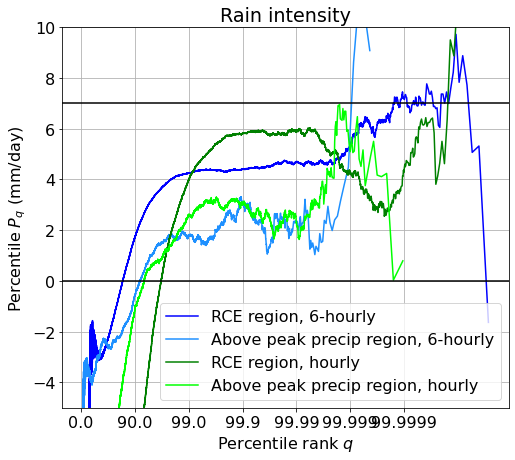

In [19]:
%%time
_,ax=plt.subplots(figsize=(8,7))

plot_deltapercentiles(ax,upstream_precip_300_sorted,upstream_precip_302_sorted,'RCE region, 6-hourly'              ,'b','-')
plot_deltapercentiles(ax,mountain_precip_300_sorted,mountain_precip_302_sorted,'Above peak precip region, 6-hourly','dodgerblue','-')

plot_deltapercentiles(ax,upstream_precip_300_hourly_sorted_sub,upstream_precip_302_hourly_sorted_sub,'RCE region, hourly',      'g','-')
plot_deltapercentiles(ax,mountain_precip_300_hourly_sorted,mountain_precip_302_hourly_sorted,'Above peak precip region, hourly','lime','-')


ax.set_title('Rain intensity')
ax.set_xlabel(r'Percentile rank $q$')
ax.set_ylabel(r'Percentile $P_q$ (mm/day)')

ax.set_xscale('function', functions=(lambda x:-np.log(100-x), lambda y:100-np.exp(-y)))
ticks = [100.-10**n for n in range(2,-5,-1)]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)

ax.set_ylim(-5,10)

ax.axhline(0.,color='k')
ax.axhline(7.,color='k')

ax.legend()
ax.grid()

## O'Gorman scaling

In [ ]:
# %%time
# # Extract data
# upstream_precip_300 = hrchannel500_11_300precip_hourly[1200:6960:6,:,2200:3000]
# upstream_precip_300.to_netcdf('/global/cscratch1/sd/qnicolas/temp/wrf/deep_upstream_precip_300.nc')
# 
# upstream_w_300   =   hrchannel500_11_300p.W_PL[1200:6960:6,:-1,:,2200:3000]
# upstream_rho_300 = hrchannel500_11_300p.RHO_PL[1200:6960:6,:-1,:,2200:3000]
# upstream_t_300   =   hrchannel500_11_300p.T_PL[1200:6960:6,:-1,:,2200:3000]
# upstream_w_300   = upstream_w_300.where(upstream_w_300 > -100)  
# upstream_rho_300 = upstream_rho_300.where(upstream_rho_300 >0.)  
# upstream_t_300   = upstream_t_300.where(upstream_t_300 >100.)  
# upstream_w_300.to_dataset().to_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/upstream_w_300.zarr')
# upstream_rho_300.to_dataset().to_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/upstream_rho_300.zarr')
# upstream_t_300.to_dataset().to_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/upstream_t_300.zarr')
# 
# mountain_precip_300 = hrchannel500_11_300precip_hourly[1200:6960,:,1650:1655]
# mountain_precip_300.to_netcdf('/global/cscratch1/sd/qnicolas/temp/wrf/mountain_precip_300.nc')
# 
# mountain_w_300   = hrchannel500_11_300p.W_PL[1200:6960,:-1,:,1650:1655]
# mountain_rho_300 = hrchannel500_11_300p.RHO_PL[1200:6960,:-1,:,1650:1655]
# mountain_t_300   = hrchannel500_11_300p.T_PL[1200:6960,:-1,:,1650:1655]
# mountain_w_300   = mountain_w_300.where(mountain_w_300 > -100)  
# mountain_rho_300 = mountain_rho_300.where(mountain_rho_300 >0.)  
# mountain_t_300   = mountain_t_300.where(mountain_t_300 >100.)  
# mountain_w_300.to_dataset().to_zarr(  '/global/cscratch1/sd/qnicolas/temp/wrf/mountain_w_300.zarr')
# mountain_rho_300.to_dataset().to_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/mountain_rho_300.zarr')
# mountain_t_300.to_dataset().to_zarr(  '/global/cscratch1/sd/qnicolas/temp/wrf/mountain_t_300.zarr')
#
# upstream_w_300   = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/upstream_w_300.zarr').W_PL
# upstream_rho_300 = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/upstream_rho_300.zarr').RHO_PL
# (-9.81*upstream_rho_300*upstream_w_300).to_dataset(name="OMEGA_PL").to_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/upstream_omega_300.zarr')
# mountain_w_300   = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/mountain_w_300.zarr').W_PL
# mountain_rho_300 = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/mountain_rho_300.zarr').RHO_PL
# (-9.81*mountain_rho_300*mountain_w_300).to_dataset(name="OMEGA_PL").to_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/mountain_omega_300.zarr')

In [75]:
%%time
# Extract data
upstream_precip_302 = hrchannel500_11_302precip_hourly[1200:6960:6,:,2200:3000]
upstream_precip_302.to_netcdf('/global/cscratch1/sd/qnicolas/temp/wrf/deep_upstream_precip_302.nc')

upstream_w_302   =   hrchannel500_11_302p.W_PL[1200:6960:6,:-1,:,2200:3000]
upstream_rho_302 = hrchannel500_11_302p.RHO_PL[1200:6960:6,:-1,:,2200:3000]
upstream_t_302   =   hrchannel500_11_302p.T_PL[1200:6960:6,:-1,:,2200:3000]
upstream_w_302   = upstream_w_302.where(upstream_w_302 > -100)  
upstream_rho_302 = upstream_rho_302.where(upstream_rho_302 >0.)  
upstream_t_302   = upstream_t_302.where(upstream_t_302 >100.)  
upstream_w_302.to_dataset().to_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/upstream_w_302.zarr')
upstream_rho_302.to_dataset().to_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/upstream_rho_302.zarr')
upstream_t_302.to_dataset().to_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/upstream_t_302.zarr')

mountain_precip_302 = hrchannel500_11_302precip_hourly[1200:6960,:,1650:1655]
mountain_precip_302.to_netcdf('/global/cscratch1/sd/qnicolas/temp/wrf/mountain_precip_302.nc')

mountain_w_302   = hrchannel500_11_302p.W_PL[1200:6960,:-1,:,1650:1655]
mountain_rho_302 = hrchannel500_11_302p.RHO_PL[1200:6960,:-1,:,1650:1655]
mountain_t_302   = hrchannel500_11_302p.T_PL[1200:6960,:-1,:,1650:1655]
mountain_w_302   = mountain_w_302.where(mountain_w_302 > -100)  
mountain_rho_302 = mountain_rho_302.where(mountain_rho_302 >0.)  
mountain_t_302   = mountain_t_302.where(mountain_t_302 >100.)  
mountain_w_302.to_dataset().to_zarr(  '/global/cscratch1/sd/qnicolas/temp/wrf/mountain_w_302.zarr')
mountain_rho_302.to_dataset().to_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/mountain_rho_302.zarr')
mountain_t_302.to_dataset().to_zarr(  '/global/cscratch1/sd/qnicolas/temp/wrf/mountain_t_302.zarr')

upstream_w_302   = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/upstream_w_302.zarr').W_PL
upstream_rho_302 = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/upstream_rho_302.zarr').RHO_PL
(-9.81*upstream_rho_302*upstream_w_302).to_dataset(name="OMEGA_PL").to_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/upstream_omega_302.zarr')
mountain_w_302   = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/mountain_w_302.zarr').W_PL
mountain_rho_302 = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/mountain_rho_302.zarr').RHO_PL
(-9.81*mountain_rho_302*mountain_w_302).to_dataset(name="OMEGA_PL").to_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/mountain_omega_302.zarr')

CPU times: user 1min 56s, sys: 1min 3s, total: 2min 59s
Wall time: 26min 6s


In [23]:
plevs = hrchannel500_11_300p.P_PL[0].load()[:-1]
upstream_precip_300= xr.open_dataarray('/global/cscratch1/sd/qnicolas/temp/wrf/upstream_precip_300.nc')
upstream_t_300     = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/upstream_t_300.zarr').T_PL
upstream_omega_300 = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/upstream_omega_300.zarr').OMEGA_PL
mountain_precip_300= xr.open_dataarray('/global/cscratch1/sd/qnicolas/temp/wrf/mountain_precip_300.nc')
mountain_t_300     = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/mountain_t_300.zarr').T_PL
mountain_omega_300 = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/mountain_omega_300.zarr').OMEGA_PL

In [76]:
plevs = hrchannel500_11_302p.P_PL[0].load()[:-1]
upstream_precip_302 = xr.open_dataarray('/global/cscratch1/sd/qnicolas/temp/wrf/upstream_precip_302.nc')
upstream_t_302      = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/upstream_t_302.zarr').T_PL
upstream_omega_302  = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/upstream_omega_302.zarr').OMEGA_PL
mountain_precip_302 = xr.open_dataarray('/global/cscratch1/sd/qnicolas/temp/wrf/mountain_precip_302.nc')
mountain_t_302      = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/mountain_t_302.zarr').T_PL
mountain_omega_302  = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/mountain_omega_302.zarr').OMEGA_PL

FileNotFoundError: [Errno 2] No such file or directory: b'/global/cscratch1/sd/qnicolas/temp/wrf/upstream_precip_302.nc'

In [27]:
def pr_ogscaling(pr,omega,t,plevs,ps,quantile_inf,quantile_sup):
    select_extremes = (pr > pr.quantile(quantile_inf)) &(pr < pr.quantile(quantile_sup))
    extreme_pr = pr.where(select_extremes).mean().load()
    extreme_t = t.where(select_extremes).mean(['Time','south_north','west_east']).load()
    extreme_omega = omega.where(select_extremes).mean(['Time','south_north','west_east']).load()
    return extreme_pr,86400*scaling(np.array(extreme_omega),np.array(extreme_t),plevs,ps)

In [ ]:
def plot_pr_ogscaling(pr,omega,t,plevs,ps,nquantiles=10):
    quantiles = 100-np.exp(np.log(10.)*np.linspace(-3,1,nquantiles))[::-1]
    
    qis = quantiles[:-1]
    qss = quantiles[1:]
    q = (qis+qss)/2
    prs=[]
    prs_og=[]
    for qi,qs in zip(qis,qss):
        p,po = pr_ogscaling(pr,omega,t,plevs,ps,qi/100,qs/100)
        prs.append(p)
        prs_og.append(po)
        
    _,ax=plt.subplots(1,1,figsize=(8,7)) 

    ax.set_title('Rain intensity')
    ax.set_xlabel(r'Percentile rank $q$')
    ax.set_ylabel(r'Percentile $P_q$ (mm/day)')
    
    ax.set_xscale('function', functions=(lambda x:-np.log(100-x), lambda y:100-np.exp(-y)))
    ticks = [100.-10**n for n in range(2,-5,-1)]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    
    ax.legend()
    ax.grid()
    return ax,q,prs,prs_og

In [ ]:
%%time
ax,q,prs_upstream,prs_og_upstream=plot_pr_ogscaling(upstream_precip_300,upstream_omega_300,upstream_t_300,plevs,1000e2,10)
_,_,prs_upstream_302,prs_og_upstream_302=plot_pr_ogscaling(upstream_precip_302,upstream_omega_302,upstream_t_302,plevs,1000e2,10)

ax.plot(q,prs_upstream,label="WRF Precipitation rates, 300K",color='b')
ax.plot(q,prs_og_upstream,label="O'Gorman scaling, 300K",color='b',linestyle=':')
ax.plot(q,prs_upstream_302,label="WRF Precipitation rates, 302K",color='r')
ax.plot(q,prs_og_upstream_302,label="O'Gorman scaling, 302K",color='r',linestyle=':')
ax.set_title("Upstream RCE region, hourly 3km scale")  

In [ ]:
%%time
ax,q,prs_mountain,prs_og_mountain=plot_pr_ogscaling(mountain_precip_300,mountain_omega_300[:,1:],mountain_t_300[:,1:],plevs[1:],970e2,10)
_,_,prs_mountain_302,prs_og_mountain_302=plot_pr_ogscaling(mountain_precip_302,mountain_omega_302[:,1:],mountain_t_302[:,1:],plevs[1:],970e2,10)

ax.plot(q,prs_mountain,label="WRF Precipitation rates, 300K",color='b')
ax.plot(q,prs_og_mountain,label="O'Gorman scaling, 300K",color='b',linestyle=':')
ax.plot(q,prs_mountain_302,label="WRF Precipitation rates, 302K",color='r')
ax.plot(q,prs_og_mountain_302,label="O'Gorman scaling, 302K",color='r',linestyle=':')
ax.set_title("Above mountain, hourly 3km scale")  

## Composite mass flux

In [53]:
def plot_omegas(ax,pr,omega,plevs,nquantiles=4,style='-',lbl=''):
    colors=plt.cm.plasma(np.linspace(0,0.9,nquantiles))[::-1]
    quantiles_infsup = np.array([[89,91],[98.8,99.2],[99.88,99.92],[99.985,99.995]])/100
    quantiles_mid = np.array([0.9,0.99,0.999,0.9999]) 
    for i,(qi,qs) in enumerate(quantiles_infsup[:nquantiles]):
        select_extremes = (pr > pr.quantile(qi)) &(pr < pr.quantile(qs))
        extreme_omega = omega.where(select_extremes).mean(['Time','south_north','west_east']).load()
        ax.plot(extreme_omega,plevs/100,label=lbl+' '+str(quantiles_mid[i]),color=colors[i],linestyle=style)
    ax.axvline(0.,color='k',linestyle='--',linewidth=0.5)
    ax.set_ylim(1010,0)
    ax.legend()

CPU times: user 9.43 s, sys: 7.38 s, total: 16.8 s
Wall time: 25.7 s


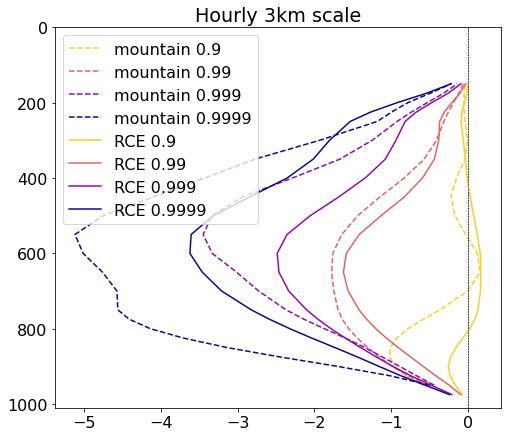

In [54]:
%%time
_,ax=plt.subplots(1,1,figsize=(8,7))
with warnings.catch_warnings():
    warnings.simplefilter("ignore",RuntimeWarning)
    plot_omegas(ax,mountain_precip_300,mountain_omega_300[:,1:],plevs[1:],nquantiles=4,style='--',lbl='mountain')
    plot_omegas(ax,upstream_precip_300,upstream_omega_300,plevs,nquantiles=4,style='-',lbl='RCE')
    ax.set_title("Hourly 3km scale")  

## Ogorman scaling - Instantaneous precip data

In [29]:
# %%time
# # Extract data
# upstream_precip_300 = deepchannel_p.RAINNCV[1200:6960:6,:,2200:3000]/16*86400 #instantaneous precip in mm/day
# upstream_precip_300.to_netcdf('/global/cscratch1/sd/qnicolas/temp/wrf/deep_upstream_precip_300.nc')
# 
# upstream_w_300   =   deepchannel_p.W_PL[1200:6960:6,:-1,:,2200:3000]
# upstream_rho_300 = deepchannel_p.RHO_PL[1200:6960:6,:-1,:,2200:3000]
# upstream_t_300   =   deepchannel_p.T_PL[1200:6960:6,:-1,:,2200:3000]
# upstream_w_300   = upstream_w_300.where(upstream_w_300 > -100)  
# upstream_rho_300 = upstream_rho_300.where(upstream_rho_300 >0.)  
# upstream_t_300   = upstream_t_300.where(upstream_t_300 >100.)  
# upstream_w_300.to_dataset().to_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/deep_upstream_w_300.zarr')
# upstream_rho_300.to_dataset().to_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/deep_upstream_rho_300.zarr')
# upstream_t_300.to_dataset().to_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/deep_upstream_t_300.zarr')

CPU times: user 14 s, sys: 8.52 s, total: 22.6 s
Wall time: 3min 49s


In [30]:
# %%time
# # Extract data
# mountain_precip_300 = deepchannel_p.RAINNCV[1200:6960,:,1650:1655]/16*86400 #instantaneous precip in mm/day
# mountain_precip_300.to_netcdf('/global/cscratch1/sd/qnicolas/temp/wrf/deep_mountain_precip_300.nc')
# 
# mountain_w_300   =   deepchannel_p.W_PL[1200:6960,:-1,:,1650:1655]
# mountain_rho_300 = deepchannel_p.RHO_PL[1200:6960,:-1,:,1650:1655]
# mountain_t_300   =   deepchannel_p.T_PL[1200:6960,:-1,:,1650:1655]
# mountain_w_300   = mountain_w_300.where(mountain_w_300 > -100)  
# mountain_rho_300 = mountain_rho_300.where(mountain_rho_300 >0.)  
# mountain_t_300   = mountain_t_300.where(mountain_t_300 >100.)  
# mountain_w_300.to_dataset().to_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/deep_mountain_w_300.zarr')
# mountain_rho_300.to_dataset().to_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/deep_mountain_rho_300.zarr')
# mountain_t_300.to_dataset().to_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/deep_mountain_t_300.zarr')

CPU times: user 48.8 s, sys: 7.61 s, total: 56.4 s
Wall time: 15min 29s


In [31]:
# %%time
# upstream_w_300   = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/deep_upstream_w_300.zarr').W_PL
# upstream_rho_300 = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/deep_upstream_rho_300.zarr').RHO_PL
# (-9.81*upstream_rho_300*upstream_w_300).to_dataset(name="OMEGA_PL").to_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/deep_upstream_omega_300.zarr')
# mountain_w_300   = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/deep_mountain_w_300.zarr').W_PL
# mountain_rho_300 = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/deep_mountain_rho_300.zarr').RHO_PL
# (-9.81*mountain_rho_300*mountain_w_300).to_dataset(name="OMEGA_PL").to_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/deep_mountain_omega_300.zarr')

CPU times: user 4.33 s, sys: 2.05 s, total: 6.38 s
Wall time: 26.5 s


In [63]:
deepplevs = deepchannel_p.P_PL[0].load()[:-1]
deep_upstream_precip_300= xr.open_dataarray('/global/cscratch1/sd/qnicolas/temp/wrf/deep_upstream_precip_300.nc')
deep_upstream_t_300     = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/deep_upstream_t_300.zarr').T_PL
deep_upstream_omega_300 = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/deep_upstream_omega_300.zarr').OMEGA_PL
deep_mountain_precip_300= xr.open_dataarray('/global/cscratch1/sd/qnicolas/temp/wrf/deep_mountain_precip_300.nc')
deep_mountain_t_300     = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/deep_mountain_t_300.zarr').T_PL
deep_mountain_omega_300 = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/deep_mountain_omega_300.zarr').OMEGA_PL

CPU times: user 38 s, sys: 28.4 s, total: 1min 6s
Wall time: 1min 43s


Text(0.5, 1.0, 'Upstream RCE region, hourly 3km scale, deep simulation (instantaneous precip)')

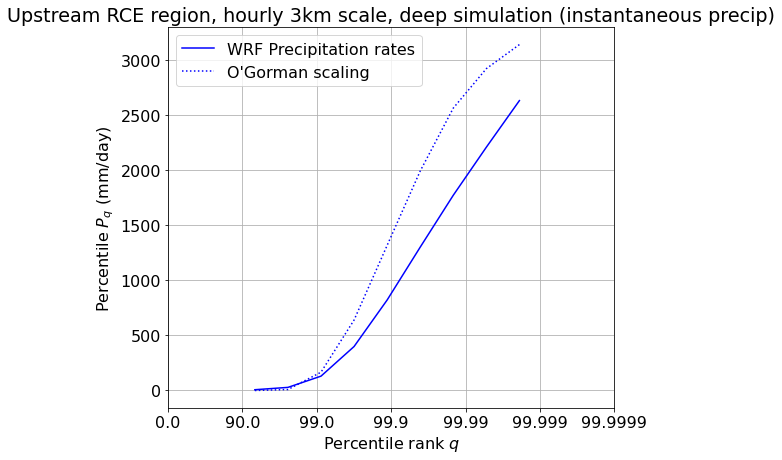

In [64]:
%%time
ax,q,prs_deep_upstream,prs_deep_og_upstream=plot_pr_ogscaling(deep_upstream_precip_300,deep_upstream_omega_300,deep_upstream_t_300,deepplevs,1000e2,10)
ax.set_title("Upstream RCE region, hourly 3km scale, deep simulation (instantaneous precip)")  

CPU times: user 4.38 s, sys: 630 ms, total: 5.01 s
Wall time: 7.87 s


Text(0.5, 1.0, 'Above mountain, hourly 3km scale, deep simulation (instantaneous precip)')

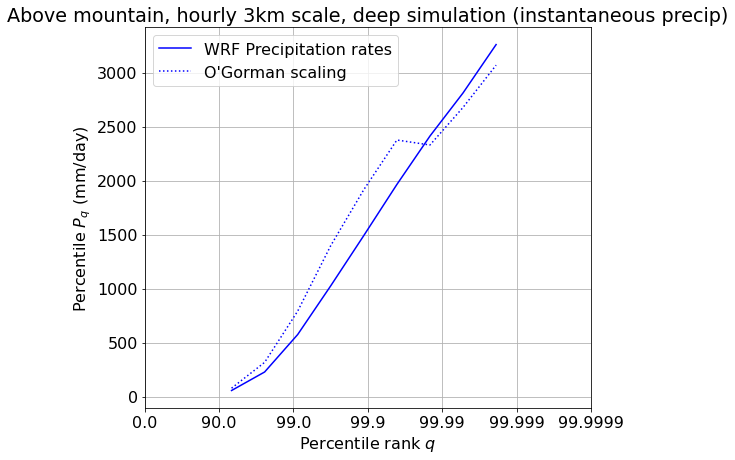

In [74]:
%%time
ax,q,prs_deep_mountain,prs_deep_og_mountain=plot_pr_ogscaling(deep_mountain_precip_300,deep_mountain_omega_300[:,2:],deep_mountain_t_300[:,2:],deepplevs[2:],970e2,10)
ax.set_title("Above mountain, hourly 3km scale, deep simulation (instantaneous precip)")  


# Daily data analysis

## 6-hourly

In [10]:
pr_timeseries = hrchannel500_11_300precip[200:,:,1635:1635+200//3].mean(['south_north','west_east']).load()

In [11]:
pressure = (hrchannel500_11_300.PB[-1,:,0,1635:1635+200//3]+hrchannel500_11_300.P[-10:,:,:,1635:1635+200//3].mean(['Time','south_north'])).load()

In [41]:
## takes 10 min
#thetaprime_timeseries = hrchannel500_11_300.T[200:,:,:,1635:1635+200//3].mean(['south_north'])
#t_timeseries = ((300+thetaprime_timeseries)*(pressure/1e5)**0.286).mean('west_east')
#q_timeseries = hrchannel500_11_300.QVAPOR[200:,:,:,1635:1635+200//3].mean(['south_north','west_east'])


In [72]:
t_timeseries = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.3km/diags/wrf.Tupstream.days50-400.nc')[:-1]
q_timeseries = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.3km/diags/wrf.qupstream.days50-400.nc')[:-1]

In [13]:
def get_bins(var,nbins):
    var_sorted = sorted(np.array(var).reshape(-1))
    quantiles=np.linspace(0.,len(var)-1,nbins+1)
    bins = [var_sorted[int(i)]  for i in quantiles]
    bin_centers = [np.mean(var_sorted[int(quantiles[i]):int(quantiles[i+1])]) for i in range(len(quantiles)-1)]
    return np.array(bins)#,np.array(bin_centers)

def get_binned(a,b,bins):
    bins=bins[(bins>float(a.min()))&(bins<float(a.max()))]
    bin_centers=(bins[1:]+bins[:-1])/2
    digitized = np.digitize(np.array(a), bins)
    bin_means = np.array([np.array(b)[digitized == i].mean() for i in range(1, len(bins))])
    return bin_centers,bin_means
def get_count(a,bins):
    bins=bins[(bins>float(a.min()))&(bins<float(a.max()))]
    bin_centers=(bins[1:]+bins[:-1])/2
    count = np.histogram(a,bins)[0]
    return bin_centers,count

In [73]:
qavg = q_timeseries[:,3:11].mean('bottom_top').load()
Navg = compute_N(t_timeseries.assign_coords({'pressure':pressure[:,0]}),1)[3:11].mean('bottom_top').load()

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [58]:
def plot_pointcloud(x,y,binning_qty,bname,bscale,bunit):
    _,ax = plt.subplots(1,1,figsize=(12,7))
    bins = get_bins(binning_qty,6)
    colors=plt.cm.jet(np.linspace(0,1,len(bins)-1))
    for i,q in enumerate(bins[:-1]):
        condition=(binning_qty>=q) & (binning_qty<bins[i+1])& (y>2.)
        xs = x.where(condition,drop=True)
        ys = y.where(condition,drop=True)
        if len(xs)!=0:
            reg = linregress(xs,ys)
            ax.scatter(xs,ys,color=colors[i],label=r'%s=%.4f, slope=%.1f %%/(%s)'%(bname,q,100*((bscale*1.1*reg.slope+reg.intercept)/(bscale*reg.slope+reg.intercept)-1),bunit))
            ax.plot(xs,reg.intercept+xs*reg.slope,color=colors[i],linestyle='--',linewidth=0.75)
    ax.legend()
    return ax

Text(0, 0.5, 'Precipitation (mm/day)')

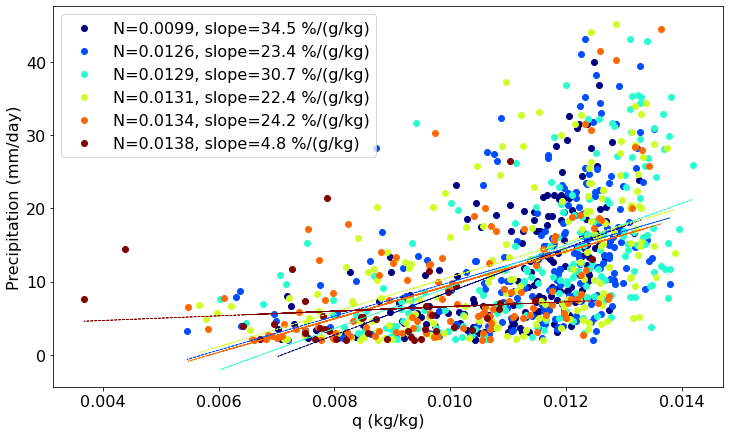

In [59]:
ax=plot_pointcloud(qavg,pr_timeseries,Navg,'N',0.01,'g/kg')
ax.set_xlabel("q (kg/kg)")
ax.set_ylabel("Precipitation (mm/day)")

Text(0, 0.5, 'Precipitation (mm/day)')

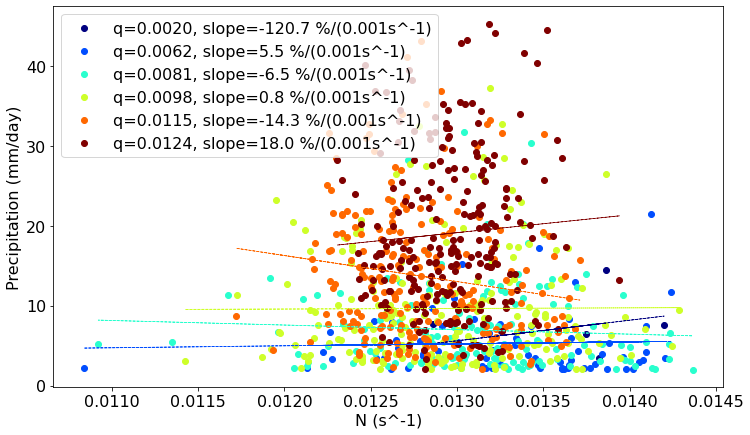

In [60]:
# Binning by humidity

ax=plot_pointcloud(Navg,pr_timeseries,qavg,'q',0.01,'0.001s^-1')
ax.set_xlabel("N (s^-1)")
ax.set_ylabel("Precipitation (mm/day)")

In [63]:
def plot_binned_pointcloud(x,y,xbins,binning_qty,bname,bscale,bunit):
    _,(ax,ax2) = plt.subplots(2,1,figsize=(12,11))
    bins = get_bins(binning_qty,6)
    colors=plt.cm.jet(np.linspace(0,1,len(bins)-1))
    for i,q in enumerate(bins[:-1]):
        condition=(binning_qty>=q) & (binning_qty<bins[i+1])& (y>2.)
        xs = x.where(condition,drop=True)
        ys = y.where(condition,drop=True)
        if len(xs)!=0:
            bin_centers,bin_means = get_binned(xs,ys,xbins)
            reg = linregress(bin_centers,bin_means)
            ax.plot(bin_centers,bin_means,'-x',color=colors[i],label=r'%s=%.4f, slope=%.1f %%/(%s)'%(bname,q,100*((bscale*1.1*reg.slope+reg.intercept)/(bscale*reg.slope+reg.intercept)-1),bunit))
            ax.plot(bin_centers,reg.intercept+bin_centers*reg.slope,color=colors[i],linestyle='--',linewidth=0.75)
            bin_centers,count = get_count(xs,xbins)
            ax2.plot(bin_centers,count,'-x',color=colors[i],label=r'%s=%.4f'%(bname,q))  
    ax.legend()
    return ax,ax2

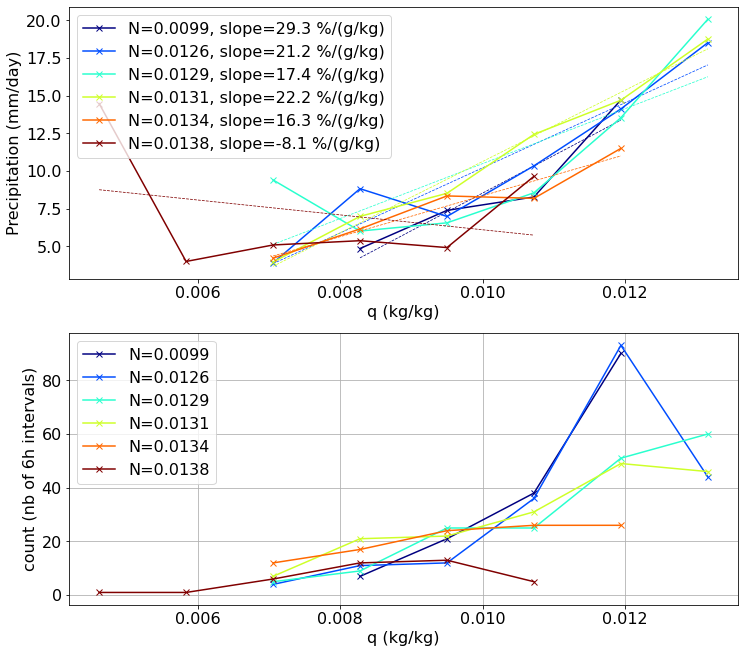

In [66]:
# Binning by humidity
ax,ax2 = plot_binned_pointcloud(qavg,pr_timeseries,np.linspace(0.004,0.015,10),Navg,'N',0.01,'g/kg')

ax.set_xlabel("q (kg/kg)")
ax.set_ylabel("Precipitation (mm/day)")
ax.legend()

ax2.set_xlabel("q (kg/kg)")
ax2.set_ylabel("count (nb of 6h intervals)")
ax2.legend()
ax2.grid()

## Daily resolution

In [74]:
pr_timeseries_daily = pr_timeseries.coarsen(Time=4).mean()
t_timeseries_daily = t_timeseries.coarsen(Time=4).mean()
q_timeseries_daily = q_timeseries.coarsen(Time=4).mean()

In [75]:
qavg_daily = q_timeseries_daily[:,3:11].mean('bottom_top').load()
Navg_daily = compute_N(t_timeseries_daily.assign_coords({'pressure':pressure[:,0]}),1)[3:11].mean('bottom_top').load()

Text(0, 0.5, 'Precipitation (mm/day)')

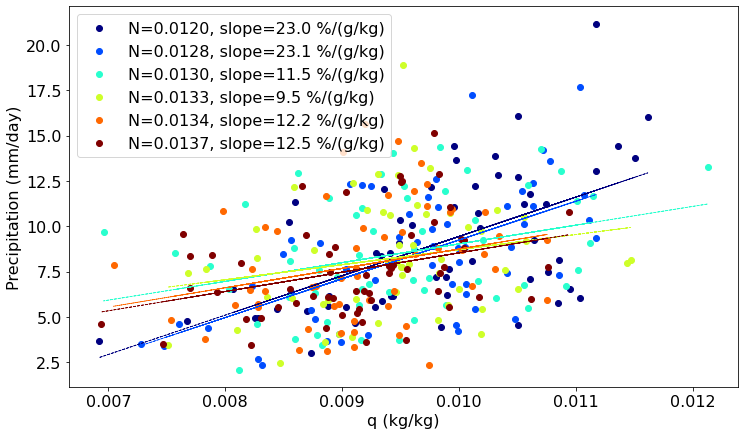

In [76]:
ax=plot_pointcloud(qavg_daily,pr_timeseries_daily,Navg_daily,'N',0.01,'g/kg')
ax.set_xlabel("q (kg/kg)")
ax.set_ylabel("Precipitation (mm/day)")

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice.
  if sys.path[0] == '':
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice.
  if sys.path[0] == '':
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


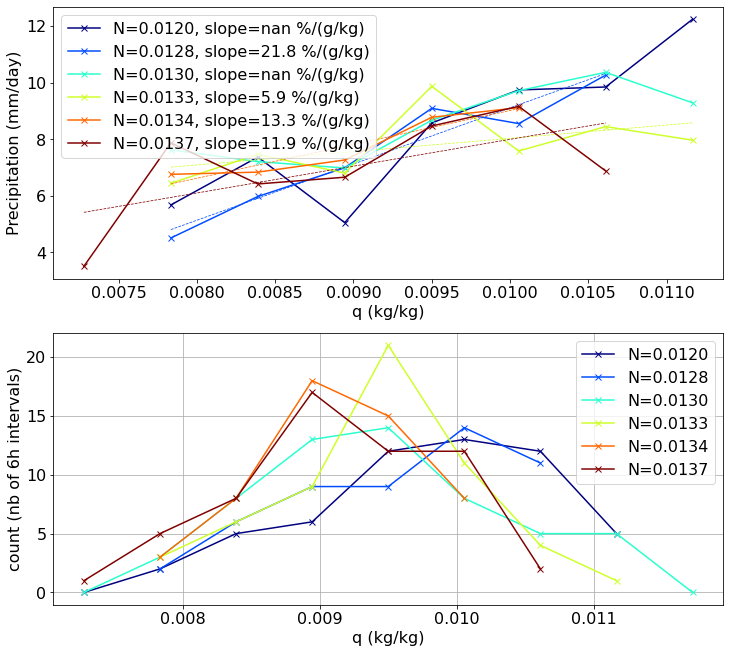

In [78]:
# Binning by humidity
ax,ax2 = plot_binned_pointcloud(qavg_daily,pr_timeseries_daily,np.linspace(0.007,0.012,10),Navg_daily,'N',0.01,'g/kg')

ax.set_xlabel("q (kg/kg)")
ax.set_ylabel("Precipitation (mm/day)")
ax.legend()

ax2.set_xlabel("q (kg/kg)")
ax2.set_ylabel("count (nb of 6h intervals)")
ax2.legend()
ax2.grid()